# Simple Linear Regression

## Import needed packages

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
root_path = Path(".").absolute()
data_path = root_path / "data"
data_path.mkdir(exist_ok=True)

%matplotlib inline

## Load the data

<p>The dataset you will see resides at the following URL. You can use the URL directly with the Pandas library to load the dataset.</p>

In [3]:
# url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"

file = data_path / "FuelConsumptionCo2.csv"
df = pd.read_csv(file)

<p>Verify successful load with some randomly selected records.</p>

In [4]:
df.sample(5)

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
448,2014,GMC,SAVANA 2500 PASSENGER,VAN - PASSENGER,6.0,8,A6,X,21.9,15.0,18.8,15,432
743,2014,MERCEDES-BENZ,E 350 4MATIC WAGON,STATION WAGON - MID-SIZE,3.5,6,AS7,Z,12.1,8.6,10.5,27,242
539,2014,INFINITI,Q70 HYBRID,MID-SIZE,3.5,6,AS7,Z,8.0,7.0,7.6,37,175
485,2014,HONDA,ACCORD,MID-SIZE,3.5,6,AS6,X,11.4,7.3,9.6,29,221
963,2014,SUBARU,XV CROSSTREK AWD,SUV - SMALL,2.0,4,M5,X,10.2,8.0,9.2,31,212


## Understand the data

<p>You will use a fuel consumption dataset, <code>FuelConsumption.csv</code>, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. Click <a href="https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64">here</a> to see the dataset source.</p>
<p>Column Name</p>
<ul>
    <li>MODEL YEAR</li>
    <li>MAKE</li>
    <li>MODEL</li>
    <li>VEHICLE CLASS</li>
    <li>ENGINE SIZE</li>
    <li>CYLINDERS</li>
    <li>TRANSMISSION</li>
    <li>FUEL TYPE</li>
    <li>FUEL CONSUMPTION in CITY (L/100 km)</li>
    <li>FUEL CONSUMPTION in HWY (L/100 km)</li>
    <li>FUEL CONSUMPTION COMBINED (L/100 km)</li>
    <li>FUEL CONFUMPTION COMBINED MPG (MPG)</li>
    <li>CO2 EMISSIONS (g/km)</li>
</ul>
<p>Your task will be to create a simple linear regression model from one of these features to predict CO<sub>2</sub> emissions of unobserved cars based on that feature.</p>

## Explore the data

<p>First, consider a statistical summary of the data.</p>

In [5]:
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


<p>From the data, we can see that most cars (about 75%) have a fuel efficiency between 11 and 31 MPG. However, one car shows a value of 60 MPG, which is much higher than the rest. This could either be a valid reading for a highly efficient or hybrid vehicle, or it might be an outlier or a data entry error.</p>
<p><code>MODEL YEAR</code> has 0 standard deviation, and thus has no interesting information content.</p>

### Select features

<p>Select a few features that might be indicative of CO<sub>2</sub> emission to explore more.</p>

In [6]:
cdf = df.loc[:, ["ENGINESIZE", "CYLINDERS", "FUELCONSUMPTION_COMB", "CO2EMISSIONS"]]
cdf.sample(9)

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
147,3.6,6,16.5,264
392,1.6,4,7.6,175
283,5.7,8,12.8,294
74,6.0,12,16.5,380
403,2.0,4,7.8,179
575,2.4,4,10.9,251
324,3.6,6,12.1,278
882,3.8,6,11.9,274
1052,2.0,4,11.6,267


### Visualize features

<p>Consider the histograms for each of these features.</p>

array([[<Axes: title={'center': 'CYLINDERS'}>,
        <Axes: title={'center': 'ENGINESIZE'}>],
       [<Axes: title={'center': 'FUELCONSUMPTION_COMB'}>,
        <Axes: title={'center': 'CO2EMISSIONS'}>]], dtype=object)

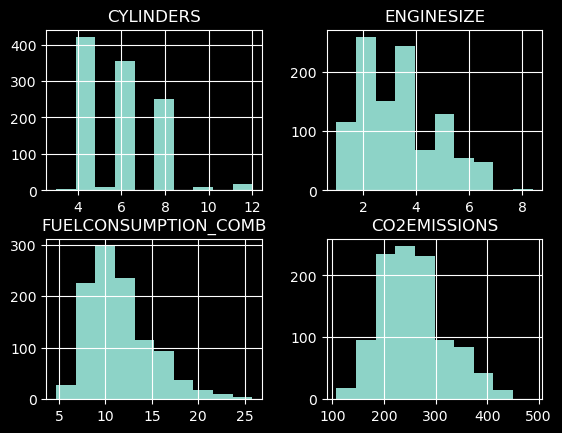

In [7]:
viz = cdf.loc[:, ["CYLINDERS", "ENGINESIZE", "FUELCONSUMPTION_COMB", "CO2EMISSIONS"]]
viz.hist()

<p>As you can see, most engines have 4, 6, or 8 cylinders, and engine sizes between 2 and 4 liters.</p>
<p>As you might expect, combined fuel consumption and CO<sub>2</sub> emission have very similar distributions.</p>
<p>Go ahead and display some scatter plots of these features against the CO<sub>2</sub> emissions, to see how linear their relationships are.</p>

Text(0, 0.5, 'CO2 Emission')

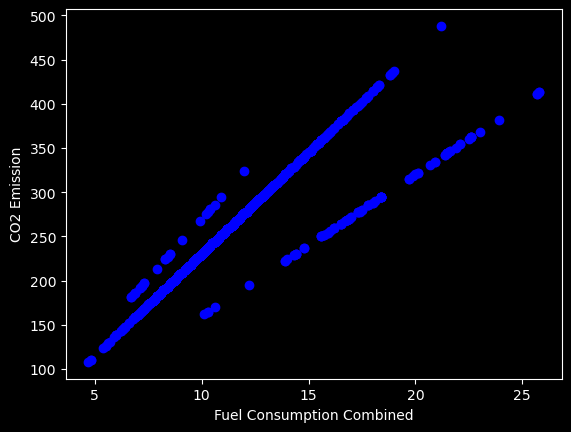

In [8]:
plt.scatter(cdf.FUELCONSUMPTION_COMB, cdf.CO2EMISSIONS, color="blue")
plt.xlabel("Fuel Consumption Combined")
plt.ylabel("CO2 Emission")

<p>This is an informative result. Three car groups each have a strong linear relationship between their combined fuel consumption and their CO<sub>2</sub> emissions. Their intercepts are similar, while they noticeably differ in their slopes.</p>

(0.0, 27.0)

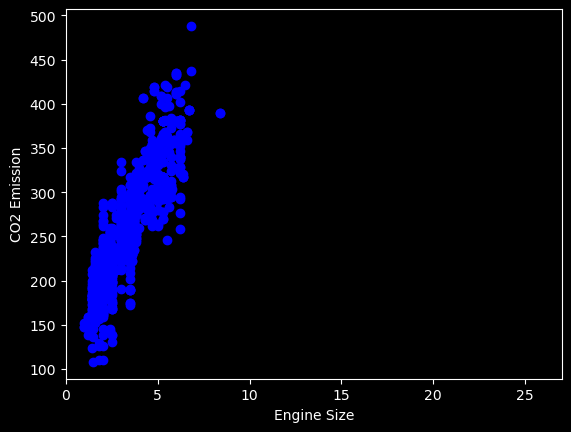

In [9]:
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS, color="blue")
plt.xlabel("Engine Size")
plt.ylabel("CO2 Emission")
plt.xlim(0, 27)

<p>Although the relationship between engine size and CO<sub>2</sub> emission is quite linear, you can see that their correlation is weaker than that for each of the three fuel consumption groups. Notice that the x-axis range has been expanded to make the two plots more comparable.</p>

### Exercise

<p>Plot <code>CYLINDER</code> against CO<sub>2</sub> emission to see how linear their relationship is.</p>

Text(0, 0.5, 'CO2 Emission')

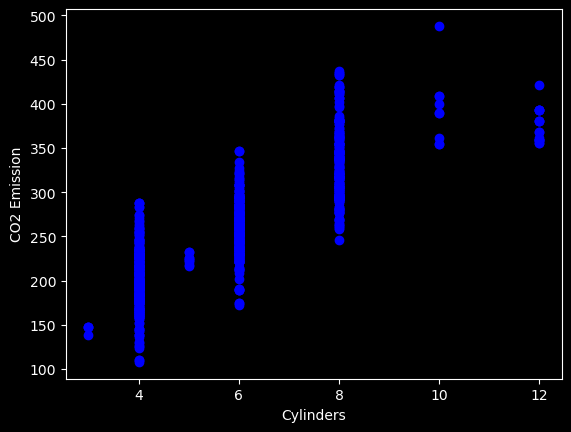

In [10]:
plt.scatter(cdf.CYLINDERS, cdf.CO2EMISSIONS, color="blue")
plt.xlabel("Cylinders")
plt.ylabel("CO2 Emission")

## Extract the input feature and labels from the dataset

<p>Although perhaps not necessary the ideal choice of input feature, for illustration purposes, you will use engine size to predict CO<sub>2</sub> emission with a linear regression model.</p>
<p>You can begin the process by extracting the input feature and target output variables, X and Y, from the dataset.</p>

In [11]:
x = cdf.ENGINESIZE.to_numpy()
y = cdf.CO2EMISSIONS.to_numpy()

### Create train and test datasets

<p>Next, you will split the dataset into mutually exclusive training and testing sets. You will train a simple linear regression model on the training set and estimate its ability to generalize to unseen data by using it to make predictions on the unseen testing data.</p>
<p>Since the outcome of each data point is part of the testing data, you have means of evaluating the out-of-sample accuracy of your model.</p>
<p>Now, you want to randomly split your data into train and test sets, using 80% of the dataset for training and reserving the remaining 20% for testing. Which fraction to use here mostly depends on the size of your data, but typical testing sizes range from 20% to 30%. The smaller your data, the larger your training set needs to be because it's easier to find spurious patterns in smaller data. The downside is that your evaluation of generalizability will have less reliability. Bigger is better when it comes to data.</p>

In [12]:
split_data: list[np.ndarray] = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = split_data

<p>The outputs are one-dimensional NumPy arrays or vectors.</p>

In [13]:
type(x_train), np.shape(x_train)

(numpy.ndarray, (853,))

## Build a simple linear regression model

<p>You'll use <code>scikit-learn</code> to build your model as follows. See <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Scikit-Learn Linear Regression Documentation</a> to learn all about the linear model predictor object.</p>

In [14]:
regressor = linear_model.LinearRegression()
regressor.fit(x_train.reshape(-1, 1), y_train)

print("Coefficients: ", regressor.coef_[0])
print("Intercept: ", regressor.intercept_)

Coefficients:  38.992978724434074
Intercept:  126.28970217408721


<p>Here, <b>Coefficient</b> and <b>Intercept</b> are the regression parameters determined by the model. They define the slope and intercept of the "best-fit" line to the training data.</p>

## Visualize model outputs

<p>You can visualize the goodness-of-fit of the model to the training data by plotting the fitted line over the data. </p>
<p>The regression model is the line given by: <code>y = intercept + coefficient * x</code>.</p>

Text(0, 0.5, 'CO2 Emission')

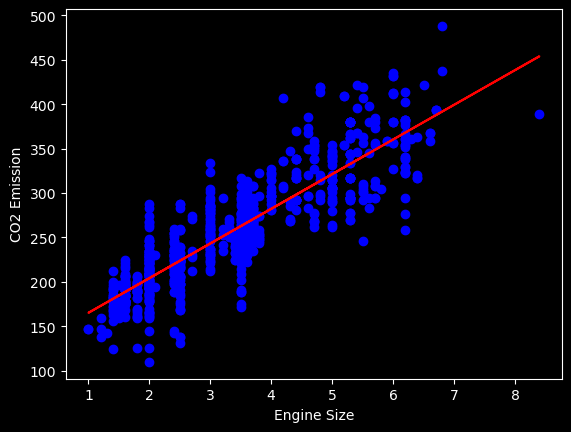

In [15]:
plt.scatter(x_train, y_train, color="blue")
plt.plot(x_train, regressor.coef_ * x_train + regressor.intercept_, "-r")
plt.xlabel("Engine Size")
plt.ylabel("CO2 Emission")

### Model evaluation

<p>You can compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics play a key role in the development of a model, as they provide insight into areas that require improvement.</p>
<p>There are different model evaluation metrics, let's use <b>MSE</b> here to calculate the accuracy of our model based on the test set:</p>
<ul>
    <li><b>Mean Absolute Error</b>: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it's just an average error.</li>
    <li><b>Mean Squared Error (MSE)</b>: MSE is the mean of the squared error. In fact, it's the metric used by the model to find the best fit line, and for that reason, it is also called the residual sum of squares.</li>
    <li><b>Root Mean Squared Error (RMSE)</b>: RMSE simply transforms the MSE into the same units as the variables being compared, which can make it easier to interpret.</li>
    <li><b>R2-Score</b> is not an error but rather a popular metric used to estimate the performance of your regression model. It represents how close the data points are to the fitted regression line. The higher the R2-Score value, the better the model fits your data. The best possible score is 1.0 and it can be negative because the model can be arbitrarily worse.</li>
</ul>

In [16]:
y_pred = regressor.predict(x_test.reshape(-1, 1))

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

Mean Absolute Error: 24.10
Mean Squared Error: 985.94
Root Mean Squared Error: 31.40
R2 Score: 0.76


## Practice exercises

<p>1. Plot the regression model result over the test data instead of the training data. Visually evaluate whether the result is good.</p>

Text(0, 0.5, 'CO2 Emission')

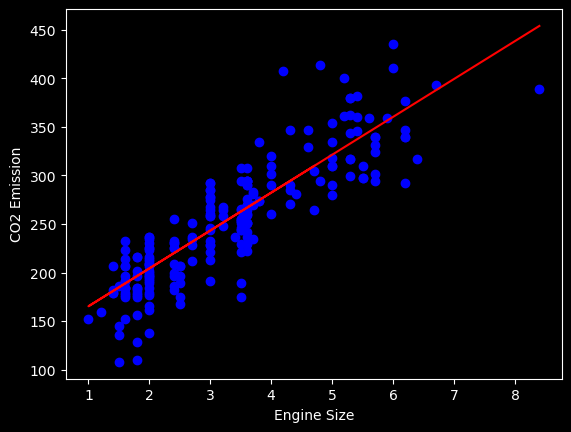

In [17]:
plt.scatter(x_test, y_test, color="blue")
plt.plot(x_test, regressor.coef_ * x_test + regressor.intercept_, "-r")
plt.xlabel("Engine Size")
plt.ylabel("CO2 Emission")

<p>Let's see the evaluation metrics if you train a regression model using the <code>FUELCONSUMPTION_COMB</code> feature.</p>

<p>2. Select the fuel consumption feature from the dataframe and split the data 80%/20% into training and testing sets. Use the same random state as previously so you can make an objective comparison to the previous training result.</p>

In [18]:
x_prac = cdf.FUELCONSUMPTION_COMB.to_numpy()
x_prac_train, x_prac_test, y_prac_train, y_prac_test = train_test_split(x_prac, y, test_size=0.2, random_state=42)

<p>3. Train a linear regression model using the training data you created. Remember to transform your 1D feature into a 2D array.</p>

In [19]:
lr = linear_model.LinearRegression()
lr.fit(x_prac_train.reshape(-1, 1), y_prac_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


<p>4. Use the model to make test predictions on the fuel consumption testing data.</p>

In [20]:
y_prac_pred = lr.predict(x_prac_test.reshape(-1, 1))

<p>5. Calculate and print the MSE of the test predictions.</p>

In [21]:
f"Mean Squared Error: {mean_squared_error(y_prac_test, y_prac_pred):.2f}"

'Mean Squared Error: 797.43'

<p>As you might expect from your exploratory analysis, the MSE is smaller when we train using <code>FUELCONSUMPTION_COMB</code> rather than <code>ENGINESIZE</code>.</p>

****
This is the end of the file.
****